In [3]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:

# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
from tool._fixedInt import *
import random
#from fxpmath import Fxp
from scipy.signal import resample, lfilter
from matplotlib.lines import Line2D
##  ipython nbconvert --to latex --post PDF <Name.ipynb>

Parámetros

In [28]:
# Punto fijo
NBin     = 8
NBFin    = 5
NBout    = 8
NBFout   = 5
NBcoeff  = 7
NBFcoeff = 5
NBmu     = 8
NBFmu    = 7
NBd      = 7
NBFd     = 5
NBe      = NBout+1
NBFe     = NBFd

#NBmult = NBin + NBmu + NBe
#NBFmult = NBFin + NBFmu + NBFe
NBsum = NBin + NBmu + NBe
NBFsum = NBFin + NBFmu + NBFe

## Parametros del filtro de caida cosenoidal
beta   = [0.0,0.5,0.99] # Roll-Off
Nbauds = 6     # Cantidad de baudios del filtro

## Parametros generales
T     = 1.0/1.0e8 # Periodo de baudio
Nsymb = 100000          # Numero de simbolos
oversampling    = 2

## Parametros de la respuesta en frecuencia
Nfreqs = 256          # Cantidad de frecuencias

## Parametros funcionales
Ts = T/oversampling              # Frecuencia de muestreo

# Parámetros del ruido
snr_db = 40 # Relación señal-ruido en decibelios
snr_linear = 10 ** (snr_db / 10) # Convertir SNR de dB a una proporción lineal

# Parametros para el LMS
mu = 0.125 # Tasa de aprendizaje
n_taps = 9  # Número de taps (coeficientes)
n_iterations = Nsymb * oversampling # Número de iteraciones
np.random.seed(0)  # Para reproducibilidad

Funciones

In [5]:
def rcosine(beta, Tbaud, oversampling, Nbauds, Norm):
    """ Respuesta al impulso del pulso de caida cosenoidal """
    t_vect = np.arange(-0.5*Nbauds*Tbaud, 0.5*Nbauds*Tbaud,
                       float(Tbaud)/oversampling)

    y_vect = []
    for t in t_vect:
        y_vect.append(np.sinc(t/Tbaud)*(np.cos(np.pi*beta*t/Tbaud)/
                                        (1-(4.0*beta*beta*t*t/
                                            (Tbaud*Tbaud)))))

    y_vect = np.array(y_vect)

    if(Norm):
        return (t_vect, y_vect/np.sqrt(np.sum(y_vect**2)))
        #return (t_vect, y_vect/y_vect.sum())
    else:
        return (t_vect,y_vect)

In [29]:
def resp_freq(filt, Ts, Nfreqs):
    """Computo de la respuesta en frecuencia de cualquier filtro FIR"""
    H = [] # Lista de salida de la magnitud
    A = [] # Lista de salida de la fase
    filt_len = len(filt)

    #### Genero el vector de frecuencias
    freqs = np.matrix(np.linspace(0,1.0/(2.0*Ts),Nfreqs))
    #### Calculo cuantas muestras necesito para 20 ciclo de
    #### la mas baja frec diferente de cero
    Lseq = 20.0/(freqs[0,1]*Ts)

    #### Genero el vector tiempo
    t = np.matrix(np.arange(0,Lseq))*Ts

    #### Genero la matriz de 2pifTn
    Omega = 2.0j*np.pi*(t.transpose()*freqs)

    #### Valuacion de la exponencial compleja en todo el
    #### rango de frecuencias
    fin = np.exp(Omega)

    #### Suma de convolucion con cada una de las exponenciales complejas
    for i in range(0,np.size(fin,1)):
        fout = np.convolve(np.squeeze(np.array(fin[:,i].transpose())),filt)
        mfout = abs(fout[filt_len:len(fout)-filt_len])
        afout = np.angle(fout[filt_len:len(fout)-filt_len])
        H.append(mfout.sum()/len(mfout))
        A.append(afout.sum()/len(afout))

    return [H,A,list(np.squeeze(np.array(freqs)))]

In [8]:
def eyediagram(data, n, offset, period, color):
    span     = 2*n
    segments = int(len(data)/span)
    xmax     = (n-1)*period
    xmin     = -(n-1)*period
    x        = list(np.arange(-n,n,)*period)
    xoff     = offset

    #plt.figure()
    for i in range(0,segments-1):
        plt.plot(x, data[(i*span+xoff):((i+1)*span+xoff)],color,linewidth=0.5)
    plt.grid(True)
    plt.xlim(xmin, xmax)
    #plt.show()

In [30]:
def arrayPuntoFijo(data, Nbits , Nfracbits, signedMode, roundMode, saturateMode):
    """Conversión de punto flotante a punto fijo en su forma para ser graficado"""
    data_fp = np.zeros(len(data))
    xdata = arrayFixedInt(Nbits, Nfracbits, data, signedMode, roundMode, saturateMode) #Transformación normal a 'DeFixedInt'
    for i in range(len(xdata)): # Para graficar data
        data_fp[i] = xdata[i].fValue

    return(data_fp)

Señales

In [10]:
#Parte 1    
betaRC = 0.3

(t,rc1) = rcosine(betaRC, T,oversampling,Nbauds,Norm=False)
rc1_fp = arrayPuntoFijo(rc1, NBin, NBFin, 'S', 'trunc', 'saturate')

symb00    = np.zeros(int(oversampling)*3+1);
symb00[oversampling:len(symb00)-1:int(oversampling)] = 1.0
rc1Symb00 = np.convolve(rc1,symb00);
rc1Symb00_fp = np.convolve(rc1_fp,symb00);
offsetPot = oversampling*((Nbauds//2)-1) + int(oversampling/2)*(Nbauds%2) + 0.5*(oversampling%2 and Nbauds%2)

registroI = [1,1,0,1,0,1,0,1,0]  #Semilla:  9'h1AA
symbolsI0 = [0] * len(rc1)  #Estas dos variables son para los vectores que se multiplican por los coeficientes
zsymbI = [] #Estos son los vectores que almacenan TODAS las muestras
yI = [0] * Nsymb * oversampling   #Salida del filtro
symbolsI = []  # Vectores a correlacionar (PRBS9)

for i in range(0,Nsymb * oversampling):    #Por cada ciclo de for se genera una muestra a la salida
    if i % oversampling == 0:     #Para oversampling
        xorI=registroI[4]^registroI[8]  #XOR entre el bit 5 y 0 (o sea, entre el elemento 4 y 8 del vector, ya que los bits van 
        registroI.insert(0,xorI)        #Inserta el resultado de la XOR a la izquierda (queda un arreglo de 10 bits en vez de 9)
        symbolsI0.insert(0  , 2*registroI[9]-1)    ;   zsymbI.insert(i, 2*registroI[9]-1)    #Transforma los 0 y 1 en -1 y 1
        symbolsI.append(2*registroI[9]-1)
        registroI.pop()                 #Elimina el bit menos significativo (ya que fue desplazado en el shift register)
    else:   #Acá se agregan los 0 para oversampling de 4 (tres 0 por cada muestra)
        symbolsI0.insert(0, 0.0)    ;   zsymbI.insert(i, 0.0)
    symbolsI0.pop()
    productosI = []
    for x in range(0,len(rc1)):
        productosI.append(symbolsI0[x] * rc1[x])
    yI[i] = np.sum(productosI)

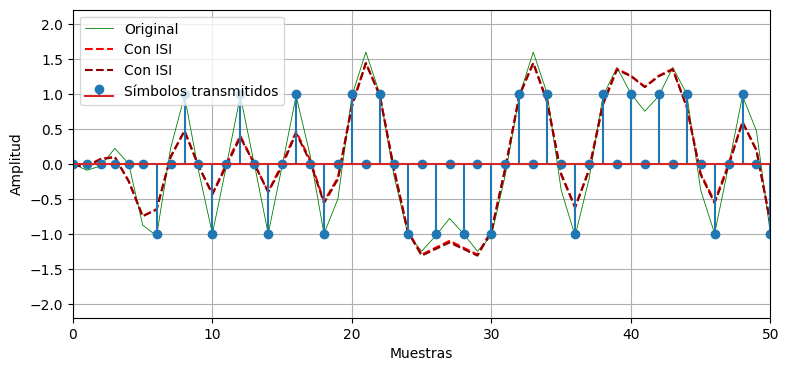

In [11]:
#Parte 2

zsymbIcorregido = [0]*(Nbauds) + zsymbI #Agrego ceros al inicio para compensar
symb_out1I = np.array(yI)
symb_out1I_fp = arrayPuntoFijo(symb_out1I, NBin, NBFin, 'S', 'trunc', 'saturate')
signal_power = np.mean(np.abs(yI)**2) # Potencia de la señal (asumimos que la señal está normalizada con potencia media = 1)
noise_power = signal_power / snr_linear # Potencia del ruido
noise = np.sqrt(noise_power) * np.random.randn(len(yI)) # Generar ruido Gaussiano Blanco (media 0, varianza noise_power)
distorted_signal = symb_out1I + noise # Señal distorsionada (señal con ruido añadido)
distorted_signal_fp = arrayPuntoFijo(distorted_signal, NBin, NBFin, 'S', 'trunc', 'saturate')

# === AÑADIR ISI y RUIDO===
# Canal con memoria simple para generar ISI controlado
#h_isi = np.array([1.0, 0.3, 0.1])      #ISI 1
#h_isi = [-0.1, 0.3, 0.5, 0.3, -0.1]    #ISI 2
#h_isi = [0.9, 0.5]                #ISI 3
#h_isi = [0.05, -0.1, 0.3, 1.0, 0.3, 0.05]    #ISI 4
#h_isi = [0.2,0.4,0.5,0.4,0.2]   #ISI 5
#h_isi = [0.04,-0.05, 0.07,-0.21,-0.5, 0.72, 0.36, 0, 0.21, 0.03, 0.07] #ISI 7 (tesisunc)
#h_isi = [0.5] #ISI 8

#h_isi = [0.9,0.4] # ISI leve informe
h_isi = [0.4,0.4,0.4] # ISI media informe
#h_isi = [0.02, -0.05, 0.1, 0.2, 0.4, 0.6, 0.4, 0.2, 0.1, -0.05, 0.02] #ISI severa informe

# alpha = 0.9 #alpha: factor de decaimiento exponencial (0 < alpha < 1)
# L = 3 #L: longitud de la respuesta al impulso del canal
# n = np.arange(L)*3
# h_isi = alpha**n
# h_isi /= np.linalg.norm(h_isi)
# print(n)

#h_isi_oversampled = np.zeros(len(h_isi) * oversampling - 1)
#h_isi_oversampled[::oversampling] = h_isi  # Intercalás con ceros
#h_isi_oversampled = resample(h_isi, len(h_isi)*oversampling)
h_isi_oversampled = h_isi

#h_isi_oversampled = h_isi_oversampled[:len(h_isi_oversampled)-1] #Quitar el último elemento
symb_out1I_isi = np.convolve(symb_out1I, h_isi_oversampled, mode='same')
symb_out1I_isi_fp = arrayPuntoFijo(symb_out1I_isi, NBin, NBFin, 'S', 'trunc', 'saturate')
symb_out1I_isi_noise = symb_out1I_isi + noise
symb_out1I_isi_noise_fp = arrayPuntoFijo(symb_out1I_isi_noise, NBin, NBFin, 'S', 'trunc', 'saturate')

#Graficos

# Opcional: Graficamos para ver la diferencia
plt.figure(figsize=(9, 4))
plt.plot(symb_out1I_fp[:100],'g',linewidth=0.6, label='Original')
plt.plot(symb_out1I_isi[:100],'r', label='Con ISI', linestyle='--')
plt.plot(symb_out1I_isi_fp[:100],'darkred', label='Con ISI', linestyle='--')
#plt.plot(distorted_signal[:100],'purple', label='Con AWGN', linestyle='--')
#plt.plot(symb_out1I_isi_noise[:100],'gold', label='Con ISI y AWGN', linestyle='--')
plt.stem(zsymbIcorregido[:100], label='Símbolos transmitidos')
#plt.stem(symb_out1I_isi_noise_decision[:100],'orange')
plt.legend()
#plt.title('Señal Original vs. Señal con ISI')
plt.xlabel('Muestras')
plt.xlim(0,50)
plt.ylim(-2.2,2.2)
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

C:\Users\RamiroFerreyra\AppData\Local\Temp\ipykernel_27424\1216230272.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


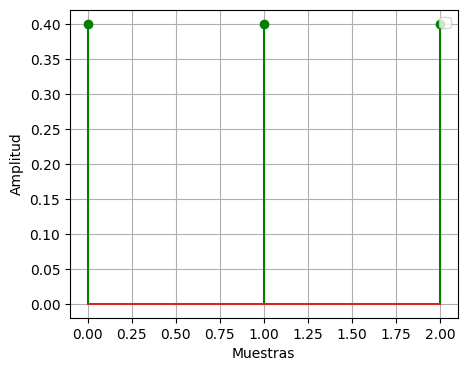

In [12]:
#Graficar ISI:
plt.figure(figsize=(5, 4))
plt.stem(h_isi_oversampled,'g')
#plt.title('Respuesta al impulso del canal con ISI')
plt.legend(loc="upper right")
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

Constelación

<function matplotlib.pyplot.show(close=None, block=None)>

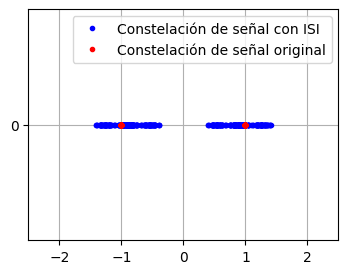

In [13]:
#Grafico de la constelacion
symb_out1I_T = symb_out1I[::oversampling]
symb_out1I_isi_noise_T = symb_out1I_isi_noise[::oversampling]


plt.figure(figsize=[4,3])
plt.plot(symb_out1I_isi_noise_T[10:511],np.zeros(len(symb_out1I_isi_noise_T[10:511])),'ob',label=r'Constelación de señal con ISI',markersize=3)
plt.plot(symb_out1I_T[10:511],np.zeros(len(symb_out1I_T[10:511])),'or',label=r'Constelación de señal original',markersize=3)
#custom_legend = [Line2D([0], [0], color='none', label='Señal QPSK (Original)')]
plt.legend(loc='upper right')
plt.yticks([0])
plt.xlim(-2.5,2.5)
plt.grid()
plt.show

Diagrama de ojo

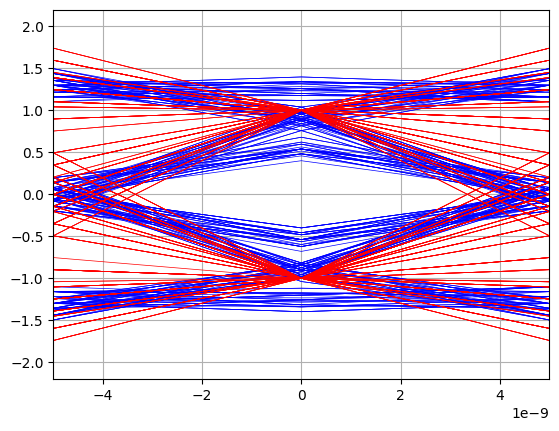

In [14]:
#Diagrama de ojo
eyediagram(symb_out1I_isi[100000:100000+(2**len(registroI)-1)*oversampling], oversampling, 0, Ts,'b')
eyediagram(symb_out1I[100000:100000+(2**len(registroI)-1)*oversampling], oversampling, 0, Ts,'r')
#eyediagram(y[100000:100000+(2**len(registroI)-1)*oversampling], oversampling, 0, Ts,'purple')
plt.ylim(-2.2,2.2)
plt.show()

Coseno realzado de entrada

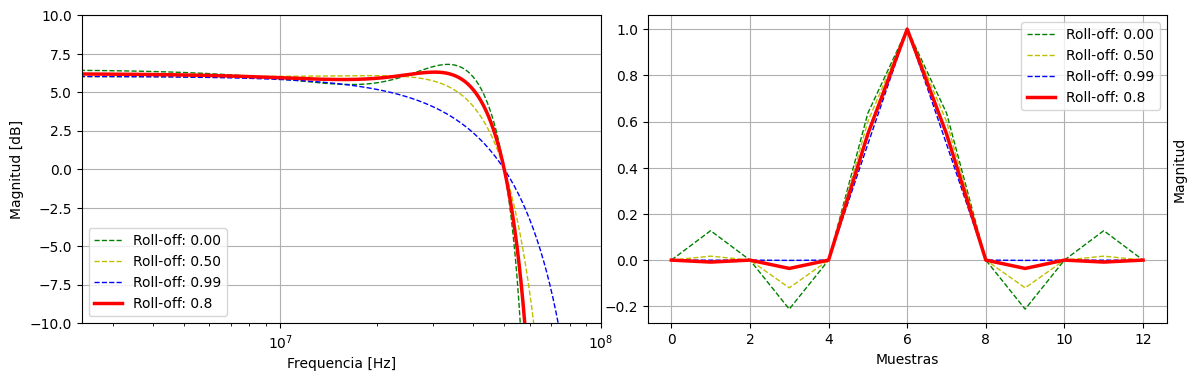

In [15]:
(t,rc02) = rcosine(beta[0], T,oversampling,Nbauds,Norm=False)
(t,rc05) = rcosine(beta[1], T,oversampling,Nbauds,Norm=False)
(t,rc09) = rcosine(beta[2], T,oversampling,Nbauds,Norm=False)
(t,rc08) = rcosine(0.8    , T,oversampling,Nbauds,Norm=False)
[H02,A02,F02] = resp_freq(rc02, Ts, Nfreqs)
[H05,A05,F05] = resp_freq(rc05, Ts, Nfreqs)
[H09,A09,F09] = resp_freq(rc09, Ts, Nfreqs)
[H08,A08,F08] = resp_freq(rc1 , Ts, Nfreqs)

### Generacion de los graficos
plt.figure(figsize=[14,4])
plt.subplot(1,4,(1,2))
plt.semilogx(F02, 20*np.log10(H02),'--g' , linewidth=1.0, label=r'Roll-off: %2.2f' %beta[0])
plt.semilogx(F05, 20*np.log10(H05),'--y' , linewidth=1.0, label=r'Roll-off: %2.2f' %beta[1])
plt.semilogx(F09, 20*np.log10(H09),'--b' , linewidth=1.0, label=r'Roll-off: %2.2f' %beta[2])
plt.semilogx(F08, 20*np.log10(H08),'red' , linewidth=2.5, label=r'Roll-off: 0.8')
plt.legend()
#plt.axvline(x=(1./Ts)/2.,color='k',linewidth=1.0)
#plt.axvline(x=(1./T)/2.,color='k',linewidth=1.0)
#plt.axhline(y=20*np.log10(0.5),color='k',linewidth=1.0)
plt.grid(True)
plt.ylim(-10,10)
plt.xlim(F09[1]+2000000,F09[len(F09)-1])#####################################ADDED
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Magnitud [dB]')

plt.subplot(1,4,(3,4))
#plt.subplot(FILAS,COLUMNAS,(16,18))
plt.plot(rc02 ,'--g' , linewidth=1.0, label=r'Roll-off: %2.2f' %beta[0])
plt.plot(rc05 ,'--y' , linewidth=1.0, label=r'Roll-off: %2.2f' %beta[1])
plt.plot(rc09 ,'--b' , linewidth=1.0, label=r'Roll-off: %2.2f' %beta[2])
plt.plot(rc08 ,'red' , linewidth=2.5, label=r'Roll-off: 0.8')
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.gca().yaxis.set_label_position("right")

plt.show()

# FSE + LMS

In [16]:
x_n = np.zeros(n_taps)
y = np.zeros(n_iterations)  # Salida del filtro
decision = [] # Salida pasada por el Slicer (decisión)
w = np.zeros(n_taps)  # Coeficientes del filtro LMS
w[len(w)//2] = 1.0
#w = np.convolve(rc1, w, mode='same')
e = []
a = 0

#Creo una matriz para los 9 coeficientes y todas las muestras de cada uno
filas_coeff = n_taps
columnas_coeff = Nsymb*oversampling
coeff = np.zeros((filas_coeff,columnas_coeff))
coeff_fp = np.zeros((filas_coeff,columnas_coeff))

for n in range(0, n_iterations-n_taps): #"n" no empieza en 0 sino en 9
    x_n = np.insert(x_n,0,symb_out1I_isi_noise[n])
    x_n = x_n[:n_taps]

    if(len(w) != len(x_n)):
        break

    y[n] = np.dot(w, x_n)  # Salida del filtro

    if(n >= 10000):
        #mu = 0.00048828125
        #mu = 0.0005
        mu = 0.03125

    if (n % oversampling == 0):
        if (y[n] > 0):
            #decision.append(1/(np.sqrt(2)))    #Para normalizado
            decision.append(1.0)                  #Para no normalizado
        elif (y[n] <= 0):
            #decision.append(-1/(np.sqrt(2)))   #Para normalizado
            decision.append(-1.0)                 #Para no normalizado
        
        e.append(decision[len(decision)-1] - y[n])  # Cálculo del error con respecto a la salida del filtro
        #w = w + mu * e[len(e)-1] * x_n  # Actualización de coeficientes del filtro

        #for i in range(0, n_taps): # Para almacenar la evolución de los coeficientes
        #    coeff[i,a] = w[i]
        #a = a + 1
    else:
        decision.append(0.0)
        e.append(0.0)

    w = w + mu * e[len(e)-1] * x_n  # Actualización de coeficientes del filtro
    for i in range(0, n_taps): # Para almacenar la evolución de los coeficientes
        coeff[i,a] = w[i]
    a = a + 1
    #if(n <= 40):
    #    print("//////////////////////////////////////////////////////////////////////////////////////////////// (",n)
    #    print("mu:\t"   ,mu  ,"\n")
    #    print("x:\t"    ,x_n ,"\n")
    #    print("y:\t"    ,y[n],"\n")
    #    print("dec:\t"  ,decision[n], "\n")
    #    print("e:\t"    ,e,"\n")
    #    print("w:\t"    ,w   ,"\n")5   

#e = np.repeat(e, oversampling)

Pruebas varias de alineación, BER, etc.

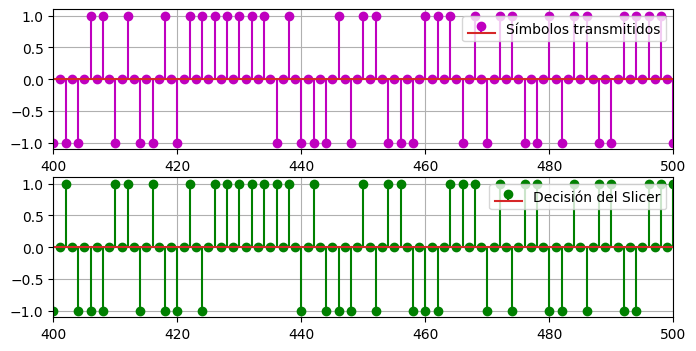

In [17]:
#zsymbI_correlation = zsymbIcorregido[4:] #Se quitan dos ceros para compensar con el efecto de la ISI
zsymbI_correlation = zsymbIcorregido #Descomentar esto en caso de no tener ISI (y comentar lo de arriba)

plt.figure(figsize=(8, 4))

plt.subplot(2,1,1)
plt.stem(zsymbI_correlation[100000:101000],'-m' , label=r'Símbolos transmitidos')
plt.grid()
plt.xlim(400,500)
plt.legend()

plt.subplot(2,1,2)
plt.stem(decision[100000:101000], '-g', label=r'Decisión del Slicer')
plt.grid()
plt.xlim(400,500)
plt.legend()

plt.show()

In [15]:
print(len(bitsDistintosDeCero))
print(len(errorTransmitido[5000:]))

NameError: name 'bitsDistintosDeCero' is not defined

In [16]:
#auxSNR = [0,1,2,3]
#auxBER = [0.09,0.07,0.05,BER_3dB]

SNR_BER = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
CurvaBER = [BER_0dB,
            BER_1dB,
            BER_2dB,
            BER_3dB,
            BER_4dB,
            BER_5dB,
            BER_6dB,
            BER_7dB,
            BER_8dB,
            BER_9dB,
            BER_10dB,
            BER_11dB,
            BER_12dB,
            BER_13dB,
            BER_14dB,
            BER_15dB]

CurvaBER_isi = [BER_0dB_isi,
            BER_1dB_isi,
            BER_2dB_isi,
            BER_3dB_isi,
            BER_4dB_isi,
            BER_5dB_isi,
            BER_6dB_isi,
            BER_7dB_isi,
            BER_8dB_isi,
            BER_9dB_isi,
            BER_10dB_isi,
            BER_11dB_isi,
            BER_12dB_isi,
            BER_13dB_isi,
            BER_14dB_isi,
            BER_15dB_isi]

from scipy.special import erfc
#Curva teórica
EbN0_dB = np.arange(0, 11, 1)  # de 0 a 10 dB
EbN0_linear = 10**(EbN0_dB / 10)
ber_theoretical = 0.5 * erfc(np.sqrt(EbN0_linear))

plt.figure(figsize=[8,4])

#plt.semilogy(auxSNR,auxBER,'m.--', linewidth=2.0)
plt.semilogy(EbN0_dB, ber_theoretical, 'b-o', label=r'BER teórica BPSK',linewidth=2.0)
plt.semilogy(SNR_BER,CurvaBER,'m.-',label=r'BER simulada (con FSE)',linewidth=2.0)
plt.semilogy(SNR_BER,CurvaBER_isi,'c.-',label=r'BER simulada (sin FSE)',linewidth=2.0)
#plt.plot(np.arange(0,16),CurvaBER,'m.-',linewidth=2.0)
plt.grid(True)
plt.xlim(0,10)
plt.legend()
plt.xlabel('SNR [dB]')
plt.ylabel('BER')

plt.show()

NameError: name 'BER_0dB' is not defined

##### FSE + LMS en punto fijo

In [18]:
#Entrada del filtro
x_n_fp = np.zeros(n_taps)

#Salida del filtro
y_fp = np.zeros(n_iterations)
fy = DeFixedInt(NBout,NBFout,'S','trunc','saturate')

#Decision
decision_fp = np.zeros(n_iterations)
fdecision = DeFixedInt(NBd,NBFd,'S','trunc','saturate')

#Coeficientes
w_fp = np.zeros(n_taps)
fw_aux = DeFixedInt(NBcoeff,NBFcoeff,'S','trunc','saturate')
#w_fp[len(w_fp)//2] = 1.0

#Error LMS
e_fp = np.zeros(n_iterations)
fe = DeFixedInt(NBe,NBFe,'S','trunc','saturate')

#Tasa de aprendizaje
fmu = DeFixedInt(NBmu,NBFmu,'S','trunc','saturate')
#fmu.value = mu
fmu.value = 0.03125
mu_fp = fmu.fValue

#Productos
######mult_fp = np.zeros(n_taps)
######fmult_aux = DeFixedInt(NBmult,NBFmult,'S','trunc','saturate')

#Registro w[]
w_R_fp = np.zeros(n_taps)
fw_R_aux = DeFixedInt(NBsum,NBFsum,'S','trunc','saturate')
w_R_fp[len(w_R_fp)//2] = 1.0

a = 0

for n in range(0, n_iterations-n_taps):
#for n in range(0, 20):
    x_n_fp = np.insert(x_n_fp,0,symb_out1I_isi_noise_fp[n])
    x_n_fp = x_n_fp[:n_taps]

    if(len(w_fp) != len(x_n_fp)):
        break
    
    fy.value = np.dot(w_fp, x_n_fp)
    y_fp[n] = fy.fValue

    if (n % oversampling == 0):
        if (y_fp[n] > 0):
            fdecision.value = 1.0
        elif (y_fp[n] <= 0):
            fdecision.value = -1.0
        decision_fp[n] = fdecision.fValue
        
        fe.value = decision_fp[n] - y_fp[n]
        e_fp[n] = fe.fValue

        for i in range(0,n_taps):
            #####fmult_aux.value = mu_fp * e_fp[n] * x_n_fp[i]
            #####mult_fp[i] = fmult_aux.fValue
            #####fw_aux.value = w_fp[i] + mult_fp[i]
            #####w_fp[i] = fw_aux.fValue
            fw_R_aux.value = w_R_fp[i] + mu_fp * e_fp[n] * x_n_fp[i]
            w_R_fp[i] = fw_R_aux.fValue
            fw_aux.value = w_R_fp[i]
            w_fp[i] = fw_aux.fValue

    else:
        decision_fp[n] = 0.0
        e_fp[n] = 0.0
    
    #if(n==0 or n==1 or n==2):
    #print("//////////////////////////////////////////////////////////////////////////////////////////////// (",n)
    #print("mu:\t"   ,mu_fp  ,"\n")
    #print("x:\t"    ,x_n_fp ,"\n")
    #print("y:\t"    ,y_fp[n],"\n")
    #print("dec:\t"  ,decision_fp[n], "\n")
    #print("e:\t"    ,e_fp[n],"\n")
    #print("sum:\t"  ,w_R_fp ,"\n")
    #print("w:\t"    ,w_fp   ,"\n")

# Gráficos del FSE + LMS en punto flotante

Salida del FSE

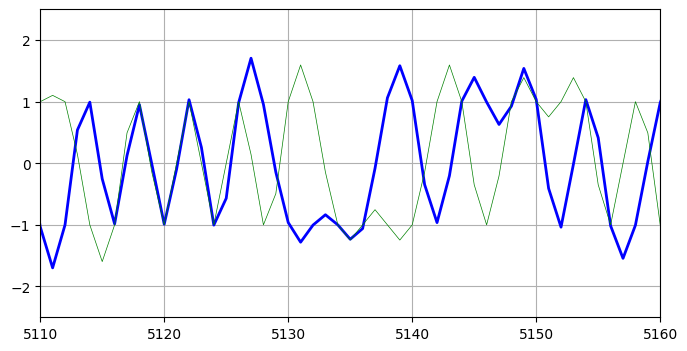

In [19]:
plt.figure(figsize=[8,4])

#plt.subplot(FILAS,COLUMNAS,(13,15))
#plt.stem(zsymbIcorregido,'g-',label=r'Simbolos')
plt.plot(y[8:],'b-',linewidth=2.0,label=r'Salida del FSE')
plt.plot(symb_out1I,'g-',linewidth=0.5,label=r'Señal original')
#plt.plot(symb_out1I_isi_noise,'r-',linewidth=0.5,label=r'Señal distorsionada')
#plt.step(zsymbI_correlation,'--',linewidth=0.5,label=r'Simbolos')
#plt.xlim(0,100)
plt.xlim(1022*5,1022*5+50)
plt.ylim(-2.5,2.5)
plt.grid(True)
#plt.legend()
#plt.xlabel('Muestras')
#plt.ylabel('Magnitud')

#print(y[190000:190050])

plt.show()

Señal de error del LMS

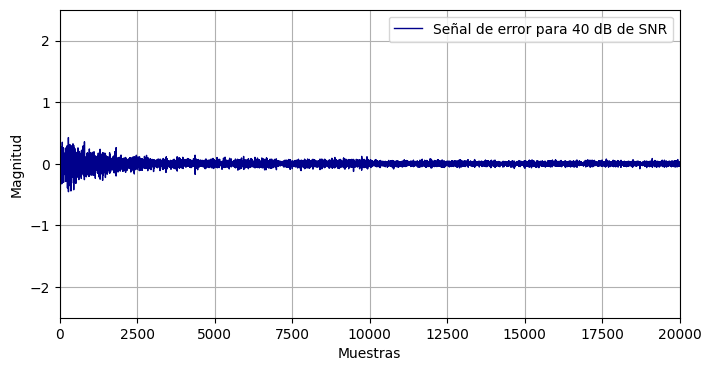

In [20]:
plt.figure(figsize=[8,4])

#plt.subplot(FILAS,COLUMNAS,(16,18))
plt.plot(e,'darkblue',linewidth=1.0,label=r'Señal de error para %2.0f dB de SNR' %snr_db)
plt.xlim(0,20000)
plt.ylim(-2.5,2.5)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')

plt.show()

Coeficientes

In [21]:
#Cada vez que ejecuto lo siguiente, cambian los colores de los taps

color = np.zeros((n_taps,3))
for i in range (0,n_taps):
    color[i] = (random.random(),random.random(),random.random())

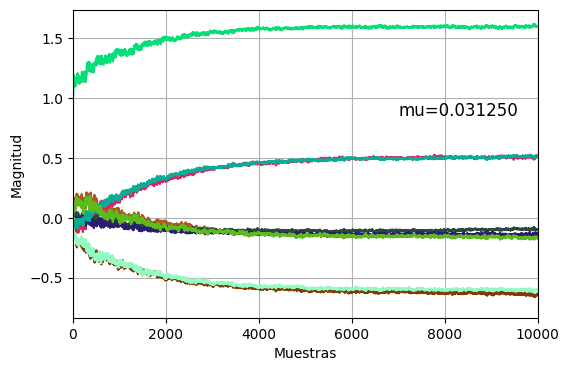

In [22]:
plt.figure(figsize=[6,4])

pi_str = str(np.pi).replace('.', '') # Convertimos pi a string y sacamos el punto
N = 17
pi_digits = [int(d) for d in pi_str[:N]] # Tomamos los primeros N dígitos
auxi = pi_digits + pi_digits

#plt.subplot(FILAS,COLUMNAS,(16,18))
for i in range (0,n_taps):
    #color = (random.random(),random.random(),random.random())  # RGB aleatorio
    #color = (i*0.006*auxi[i+2], i*0.006*auxi[i+4], i*0.006*auxi[i+6])
    plt.plot(coeff[i],color=color[i],linewidth=1.5)
plt.xlim(0,10000)
#plt.ylim(-1,1)
plt.grid(True)
#plt.text(9,1,'mu=%f'%mu, fontsize=10)
plt.text(0.70, 0.70, 'mu=%f'%mu, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top')
#plt.legend(loc='center right')
plt.xlabel('Muestras')
plt.ylabel('Magnitud')

plt.show()

Diagrama de ojo

C:\Users\RamiroFerreyra\AppData\Local\Temp\ipykernel_27424\575268825.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


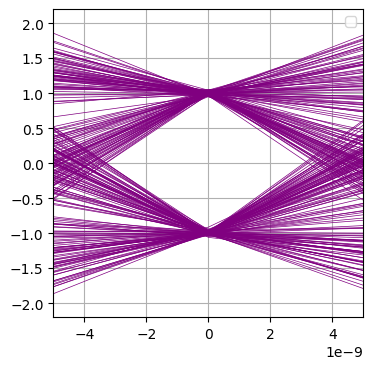

In [25]:
#Diagrama de ojo
figure = plt.figure(figsize=[4,4])
#eyediagram(symb_out1I_isi_noise[10000:10511], 2, 0, Ts,color='green')
eyediagram(y[10000:11022], 2, 0, Ts,color='purple')
#eyediagram(symb_out1I[10000:10511], 2, 0, Ts,color='gold')
plt.legend()
plt.ylim(-2.2,2.2)
plt.show()


Respuestas de cada etapa

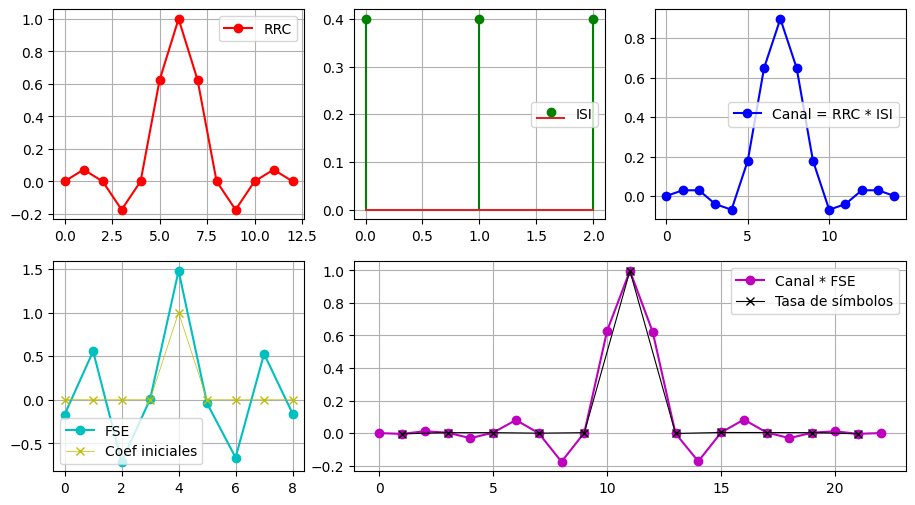

In [26]:
FSE = []
for i in range(0, n_taps):
    FSE = np.append(FSE,coeff[i,0])

RespuestaCanalTotal = np.convolve(rc1,h_isi_oversampled,mode='full')    # Canal total = Coseno realzado más ISI
#RespuestaCanalEcualizador = np.convolve(RespuestaCanalTotal,w,mode='full') # Canal total + Ecualizador
RespuestaCanalEcualizador = np.convolve(RespuestaCanalTotal,w,mode='full')

RespuestaAUX = RespuestaCanalEcualizador[1::2]

plt.figure(figsize=[11,6])

plt.subplot(2,3,1)
plt.plot(rc1,"o-r",label=r"RRC")
plt.grid(True)
plt.legend()

plt.subplot(2,3,2)
plt.stem(h_isi_oversampled,"o-g",label=r"ISI")
plt.grid(True)
plt.legend()

plt.subplot(2,3,3)
plt.plot(RespuestaCanalTotal,"o-b",label=r"Canal = RRC * ISI")
plt.grid(True)
plt.legend()

plt.subplot(2,3,4)
plt.plot(w,"o-c",label=r"FSE")
#plt.plot(w_fp, "--c",linewidth=0.5, label=r"FSE fp")
plt.plot(FSE,'x-y',linewidth=0.5,label=r"Coef iniciales")
plt.grid(True)
plt.legend()

plt.subplot(2,3,(5,6))
plt.plot(np.arange(len(RespuestaCanalEcualizador)), RespuestaCanalEcualizador,"o-m",label=r"Canal * FSE")
plt.plot(np.arange(1,len(RespuestaCanalEcualizador),2), RespuestaAUX, "x-k", linewidth=0.8,label=r"Tasa de símbolos")
#print(RespuestaCanalEcualizador)
plt.grid(True)
plt.legend()
#plt.xlabel('Muestras')
#plt.ylabel('Magnitud')

plt.show()

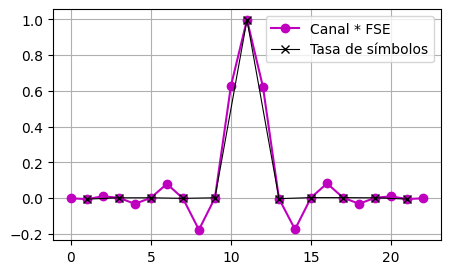

In [53]:
plt.figure(figsize=[5,3])
#plt.plot(w,"o-c",label=r"FSE")
#plt.plot(w_fp, "--c",linewidth=0.5, label=r"FSE fp")
#plt.plot(FSE,'x-y',linewidth=0.5,label=r"Coef iniciales")
plt.plot(np.arange(len(RespuestaCanalEcualizador)), RespuestaCanalEcualizador,"o-m",label=r"Canal * FSE")
plt.plot(np.arange(1,len(RespuestaCanalEcualizador),2), RespuestaAUX, "x-k", linewidth=0.8,label=r"Tasa de símbolos")

plt.grid(True)
plt.legend()
plt.show()

Respuestas en frecuencia

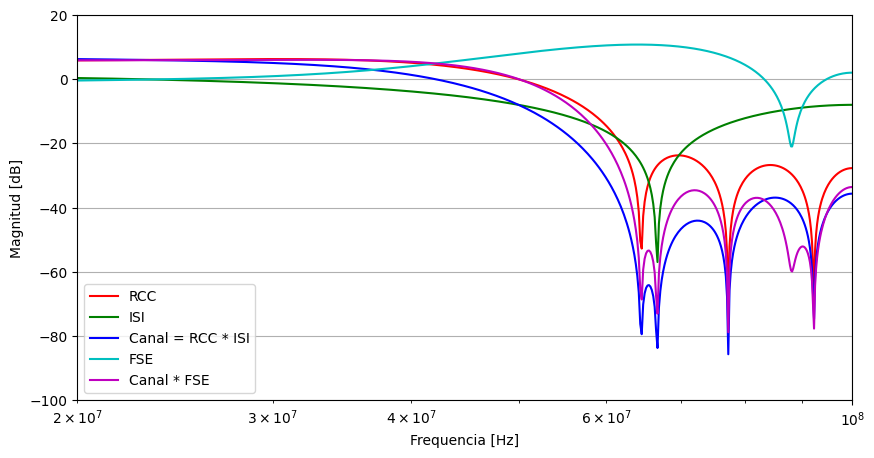

In [55]:
Nfreqs = 512

[Hrcc,Arcc,Frcc] = resp_freq(rc1 , Ts, Nfreqs)
[Hisi,Aisi,Fisi] = resp_freq(h_isi_oversampled , Ts, Nfreqs)
[Hch ,Ach ,Fch ] = resp_freq(RespuestaCanalTotal , Ts, Nfreqs)
[Hfse,Afse,Ffse] = resp_freq(w , Ts, Nfreqs)
[Htot,Atot,Ftot] = resp_freq(RespuestaCanalEcualizador , Ts, Nfreqs)

### Generacion de los graficos
plt.figure(figsize=[10,5])
plt.semilogx(Frcc, 20*np.log10(Hrcc),'r' , linewidth=1.5, label=r'RCC')
plt.semilogx(Fisi, 20*np.log10(Hisi),'g' , linewidth=1.5, label=r'ISI')
plt.semilogx(Fch , 20*np.log10(Hch ),'b' , linewidth=1.5, label=r'Canal = RCC * ISI')
plt.semilogx(Ffse, 20*np.log10(Hfse),'c' , linewidth=1.5, label=r'FSE')
plt.semilogx(Ftot, 20*np.log10(Htot),'m' , linewidth=1.5, label=r'Canal * FSE')

plt.legend()
#plt.axvline(x=(1./Ts)/2.,color='k',linewidth=1.0)
#plt.axvline(x=(1./T)/2.,color='k',linewidth=1.0)
#plt.axhline(y=20*np.log10(0.5),color='k',linewidth=1.0)
plt.grid(True)
plt.xlim(2e7,Ffse[len(Ffse)-1])#####################################ADDED
plt.ylim(-100,20)
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Magnitud [dB]')

plt.show()

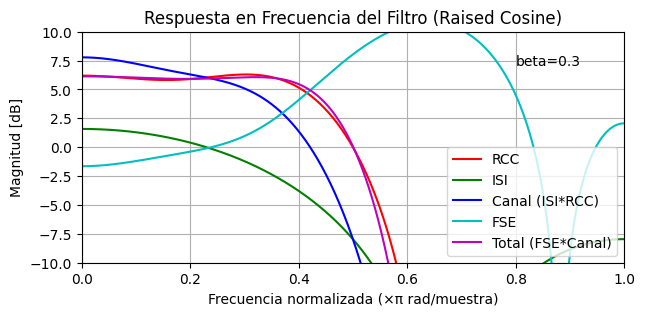

In [56]:
from scipy.signal import freqz

# Frecuencia normalizada
frecNorm, Hrcc2 = freqz(rc1, worN=Nfreqs)
frecNorm, Hisi2 = freqz(h_isi_oversampled, worN=Nfreqs)
frecNorm, Hch2  = freqz(RespuestaCanalTotal, worN=Nfreqs)
frecNorm, Hfse2 = freqz(w, worN=Nfreqs)
frecNorm, Htot2 = freqz(RespuestaCanalEcualizador, worN=Nfreqs)

# Gráfico en escala logarítmica (dB)
plt.figure(figsize=(7, 3))
plt.plot(frecNorm / np.pi, 20 * np.log10(np.abs(Hrcc2) + 1e-10),'r',label=r"RCC")  # sumo epsilon para evitar log(0)
plt.plot(frecNorm / np.pi, 20 * np.log10(np.abs(Hisi2) + 1e-10),'g',label=r"ISI")  # sumo epsilon para evitar log(0)
plt.plot(frecNorm / np.pi, 20 * np.log10(np.abs(Hch2 ) + 1e-10),'b',label=r"Canal (ISI*RCC)")  # sumo epsilon para evitar log(0)
plt.plot(frecNorm / np.pi, 20 * np.log10(np.abs(Hfse2) + 1e-10),'c',label=r"FSE")  # sumo epsilon para evitar log(0)
plt.plot(frecNorm / np.pi, 20 * np.log10(np.abs(Htot2) + 1e-10),'m',label=r"Total (FSE*Canal)")  # sumo epsilon para evitar log(0)
plt.title("Respuesta en Frecuencia del Filtro (Raised Cosine)")
plt.xlabel("Frecuencia normalizada (×π rad/muestra)")
plt.ylabel("Magnitud [dB]")
plt.ylim([-10, 10])
plt.xlim(0,1)
plt.grid(True)
plt.text(0.80, 0.90, 'beta=%1.1f'%betaRC, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top')
#plt.axvline(x=(1 + betaRC) / (2 * oversampling), color='r', linestyle='--', label='BW teórico RC')
plt.legend(loc='lower right')
plt.show()

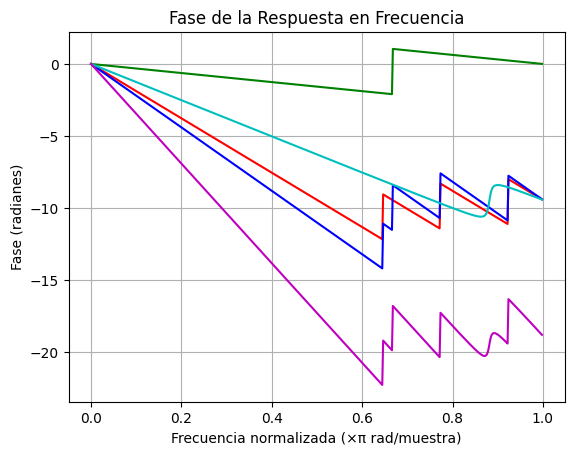

In [57]:
Prcc2 = np.unwrap(np.angle(Hrcc2))  # desenrolla la fase (evita saltos de 2π)
Pisi2 = np.unwrap(np.angle(Hisi2))
Pch2  = np.unwrap(np.angle(Hch2 ))
Pfse2 = np.unwrap(np.angle(Hfse2))
Ptot2 = np.unwrap(np.angle(Htot2))

plt.plot(frecNorm / np.pi, Prcc2,'r')
plt.plot(frecNorm / np.pi, Pisi2,'g')
plt.plot(frecNorm / np.pi, Pch2 ,'b')
plt.plot(frecNorm / np.pi, Pfse2,'c')
plt.plot(frecNorm / np.pi, Ptot2,'m')

plt.title("Fase de la Respuesta en Frecuencia")
plt.xlabel("Frecuencia normalizada (×π rad/muestra)")
plt.ylabel("Fase (radianes)")
plt.grid(True)
plt.show()

# Gráficos en punto fijo

Salida del FSE

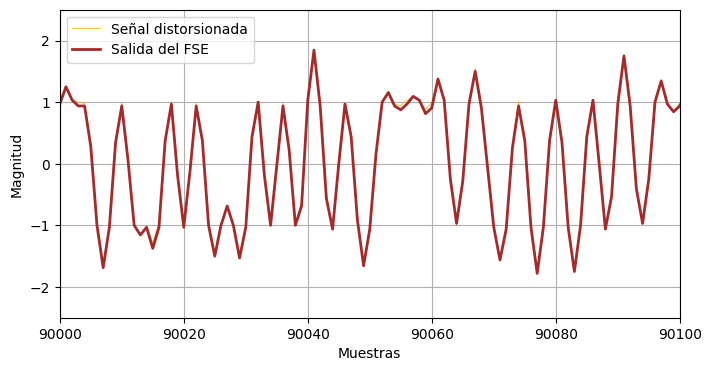

In [58]:
plt.figure(figsize=[8,4])

#plt.subplot(FILAS,COLUMNAS,(16,18))
plt.plot(y,'orange',linewidth=0.5,label=r'Señal distorsionada')
plt.plot(y_fp,'brown',linewidth=2.0,label=r'Salida del FSE') 
#plt.step(zsymbI_correlation,'--',linewidth=0.5,label=r'Simbolos')
plt.xlim(90000,90100)
plt.ylim(-2.5,2.5)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')

plt.show()

Señal de error del LMS en punto fijo

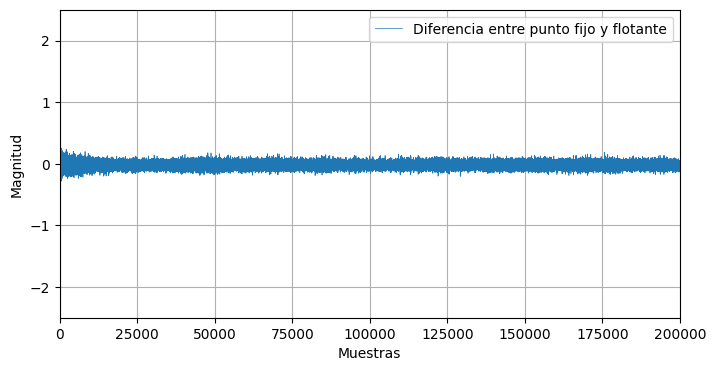

In [59]:
plt.figure(figsize=[8,4])

#plt.subplot(FILAS,COLUMNAS,(16,18))
#plt.plot(e_fp,linewidth=0.5,label=r'Señal de error para %2.0f dB en punto fijo' %snr_db)
#plt.plot(e,linewidth=0.5,label=r'Señal de error para %2.0f dB' %snr_db)
plt.plot(y_fp-y,linewidth=0.5,label=r'Diferencia entre punto fijo y flotante')
plt.xlim(0,200000)
plt.ylim(-2.5,2.5)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')

plt.show()

Histograma de error

Error absoluto medio: 0.0374744416894362
Error absoluto máximo: 0.3616868347871507


Text(0.5, 1.0, 'Histograma del error absoluto (punto flotante menos punto fijo)')

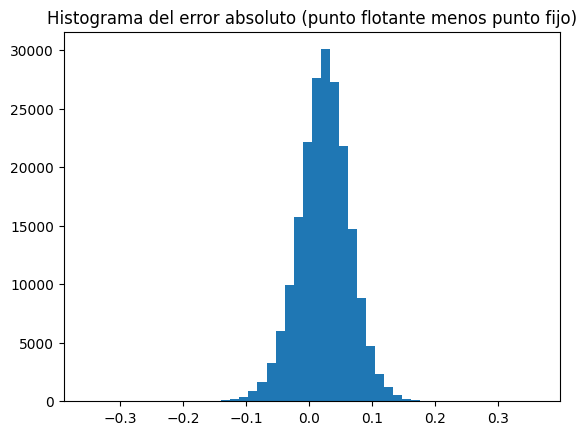

In [60]:
error_abs = np.abs(y - y_fp)
error_rel = error_abs / (np.abs(y) + 1e-12)

print("Error absoluto medio:", np.mean(error_abs))
print("Error absoluto máximo:", np.max(error_abs))

plt.hist(y-y_fp, bins=50)
plt.title("Histograma del error absoluto (punto flotante menos punto fijo)")

Generación de estímulos para el Verilog

In [ ]:
import os

folder_path = r"C:\Users\RamiroFerreyra\VivadoProjects\FSE_DDA\FSE_DDA.sim\sim_1\behav\xsim" #Cambiar a la carpeta necesaria
#os.makedirs(folder_path, exist_ok=True) #Para hacer la carpeta en caso de que quiera crearla
filename = os.path.join(folder_path, 'ENTRADA.hex')

ENTER_SIGNAL = symb_out1I_isi_noise

TamMem = len(ENTER_SIGNAL)
mem = []

aux_entrada = arrayFixedInt(NBin, NBFin, ENTER_SIGNAL, 'S', 'trunc', 'saturate') #Transformación normal a 'DeFixedInt'

with open(filename, 'w') as f:
    for index in range(TamMem):
        mem.append(aux_entrada[index])
        f.write("{}\n".format(aux_entrada[index].__hex__()).replace('0x',''))

Extracción de datos de salida del sistema:

In [ ]:
# Función para convertir hex a entero signado de 12 bits
def hex_to_signed12(h):
    val = int(h, 16)
    if val >= 2**12:  # si el bit 11 (signo) está en 1
        val -= 2**13  # convertir a negativo
    return val

# Leer archivo línea por línea
with open(r"C:\VivadoProjects\TrabajoFinalDDA\TrabajoFinalDDA.sim\sim_1\behav\xsim\resultados.txt", "r") as f:
    hex_values = [line.strip() for line in f if line.strip()]

# Convertir hex a enteros con signo
int_values = np.array([hex_to_signed12(h) for h in hex_values], dtype=np.int16)

# Convertir de punto fijo s(13;10) a float
float_values = int_values / 1024.0

# Graficar
LimA = 49000
LimB = 49100

plt.figure(figsize=(6, 6))

#plt.subplot(2,1,1)
plt.plot(float_values, 'blue', linewidth=2.0, label=r"Salida del FSE tomada del Testbench")
plt.step(float_values, 'blue', linewidth=0.5)
plt.title("Salida del ecualizador en s(13;10) desde el Testbench")
plt.ylim(-2.0, 2.0)
#plt.xlim(len(float_values)-100, len(float_values))
#plt.xlim(LimA,LimB)
plt.grid(True)
plt.legend()

# plt.subplot(2,1,2)
# plt.plot(y[4:60000], 'darkorange', linewidth=2.0, label=r"Salida del FSE simulada")
# plt.step(y[4:60000], 'darkorange', linewidth=0.5)
# plt.xlabel("Muestras")
# #plt.ylabel("Valor")
# plt.ylim(-2.0, 2.0)
# #plt.xlim(len(float_values)-100, len(float_values))
# plt.xlim(LimA,LimB)
# plt.grid(True)
# plt.legend()

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\VivadoProjects\\TrabajoFinalDDA\\TrabajoFinalDDA.sim\\sim_1\\behav\\xsim\\resultados.txt'

#### Otras pruebitas, generación de gráficos, vectores, auxiliares, etc.

C:\Users\ramir\AppData\Local\Temp\ipykernel_19516\3650066491.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\ramir\AppData\Local\Temp\ipykernel_19516\3650066491.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


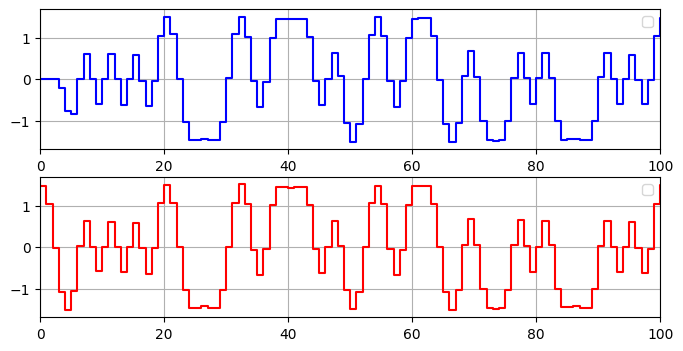

In [ ]:
#Comparación ciclos de PRBS
plt.figure(figsize=(8, 4))

plt.subplot(2,1,1)
plt.step(symb_out1I_isi_noise[0:10000],'b')
plt.grid()
plt.xlim(0,100)
plt.legend()

plt.subplot(2,1,2)
plt.step(symb_out1I_isi_noise[1022:10000], 'r')
plt.grid()
plt.xlim(0,100)
plt.legend()

plt.show()

In [ ]:
ENTER_SIGNAL = symb_out1I_isi_noise
aux_entrada = arrayFixedInt(NBin, NBFin, ENTER_SIGNAL, 'S', 'trunc', 'saturate') #Transformación normal a 'DeFixedInt'

prbsx =9
M =(2**prbsx)-1 #Son (2^n)-1 porque el valor de todo cero no está contemplado
Rango = M*oversampling
initial = 7

for i in range(Rango):
    #print("\trom[%d]"%i,"= %13.10f;"  %aux_entrada[i+Rango+initial].fValue)
    print("rom[%d] "%i,"= {NB{16'h","{}".format(aux_entrada[i+Rango+initial].__hex__()).replace('0x',''),"}};")

rom[0]  = {NB{16'h 001D }};
rom[1]  = {NB{16'h 027D }};
rom[2]  = {NB{16'h 000B }};
rom[3]  = {NB{16'h 1D9E }};
rom[4]  = {NB{16'h 1FF9 }};
rom[5]  = {NB{16'h 026D }};
rom[6]  = {NB{16'h 0009 }};
rom[7]  = {NB{16'h 1DA2 }};
rom[8]  = {NB{16'h 0007 }};
rom[9]  = {NB{16'h 0263 }};
rom[10]  = {NB{16'h 1FE5 }};
rom[11]  = {NB{16'h 1D8B }};
rom[12]  = {NB{16'h 1FE0 }};
rom[13]  = {NB{16'h 0432 }};
rom[14]  = {NB{16'h 0609 }};
rom[15]  = {NB{16'h 0457 }};
rom[16]  = {NB{16'h 000E }};
rom[17]  = {NB{16'h 1BE4 }};
rom[18]  = {NB{16'h 1A27 }};
rom[19]  = {NB{16'h 1A31 }};
rom[20]  = {NB{16'h 1A47 }};
rom[21]  = {NB{16'h 1A2A }};
rom[22]  = {NB{16'h 1A25 }};
rom[23]  = {NB{16'h 1BDF }};
rom[24]  = {NB{16'h 0014 }};
rom[25]  = {NB{16'h 0467 }};
rom[26]  = {NB{16'h 0600 }};
rom[27]  = {NB{16'h 0419 }};
rom[28]  = {NB{16'h 1FDF }};
rom[29]  = {NB{16'h 1D54 }};
rom[30]  = {NB{16'h 1FC3 }};
rom[31]  = {NB{16'h 03FC }};
rom[32]  = {NB{16'h 05BC }};
rom[33]  = {NB{16'h 05CA }};
rom[34]  = {NB{16'h 05AF

In [ ]:
#Lectura de datos del ILA
import pandas as pd

# Leer el archivo CSV
df = pd.read_csv("C:\VivadoProjects\TrabajoFinalDDA\iladata.csv")

# Extraer la columna
columna = df["u_ila/probe0_0_1[12:0]"]
columna =columna[1:].astype(int)

# Configuración: cantidad de bits
NBITS = 13
FRAC_BITS = 10
MAXVAL = 2 ** NBITS
HEX_WIDTH = NBITS // 4  # 2 para 8 bits, 4 para 16 bits, etc.

# Convertir a hexadecimal en complemento a dos
hexadecimales = [
    format(valor % MAXVAL, f'0{HEX_WIDTH}X')  # complemento a 2 y hexa
    for valor in columna
]

# Mostrar resultados
#for dec, hexa in zip(columna, hexadecimales):
#    print(f"{int(dec):+4d} \t-> {hexa}")

# Función para interpretar hexadecimal como s(13;10)
def hexa_to_s13_10(hexa):
    entero = int(hexa, 16)
    
    # Interpretar como valor signado en complemento a dos
    if entero >= 2**(NBITS - 1):
        entero -= MAXVAL  # convertir a número negativo

    # Convertir a punto fijo real dividiendo por 2^10
    valor_real = entero / (2 ** FRAC_BITS)
    return valor_real

# Aplicarlo a cada hexadecimal
valores_s13_10 = [hexa_to_s13_10(h) for h in hexadecimales]

# Mostrar resultado
#for h, v in zip(hexadecimales, valores_s13_10):
    #print(f"0x{h} -> {v:.6f}")

print(len(valores_s13_10))


1024


In [ ]:
from ipywidgets import interact, IntSlider


# Función para graficar una ventana de la señal
def mostrar_ventana(offset):
    plt.figure(figsize=(12, 3))
    plt.plot(float_values[4000:7000])
    plt.xlim(offset, offset + 1024)  # Ventana de 20 unidades
    plt.title(f"Ventana centrada en x = {offset}")
    plt.grid(True)
    plt.show()

# Slider interactivo
interact(mostrar_ventana, offset=IntSlider(min=0, max=2048, step=1, value=0))


ModuleNotFoundError: No module named 'ipywidgets'

In [ ]:
c=764+1022*5

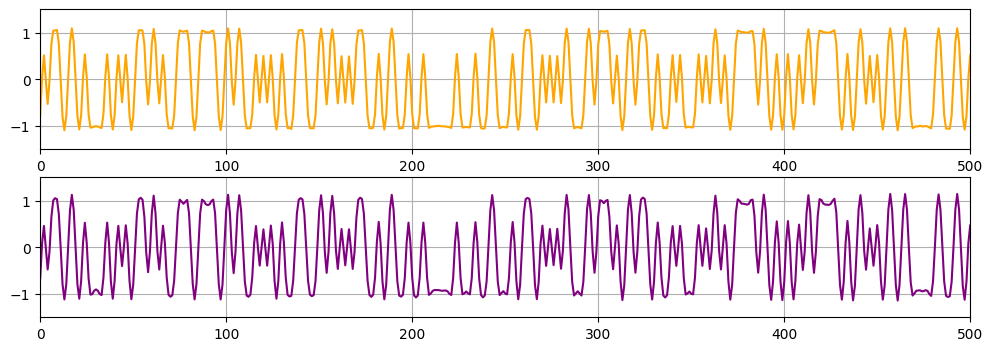

In [ ]:
#c=3500

plt.figure(figsize=(12, 4))
plt.subplot(2,1,1)
plt.plot(valores_s13_10,'orange')
plt.xlim(0, 500)
plt.ylim(-1.5, 1.5)
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(float_values[c:c+1024],'purple')
plt.xlim(0, 500)
plt.ylim(-1.5, 1.5)
plt.grid(True)

plt.show()

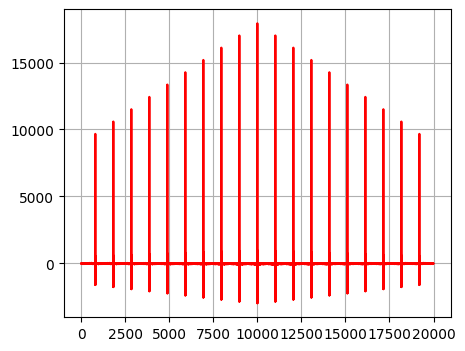

In [ ]:
c=20000

#correlationAux = np.correlate(valores_s13_10, valores_s13_10, mode='full') #Correlacion ideal
correlation_ILA_Py = np.correlate(y[:20000],y[:20000], mode='same') #Correlacion ILA vs. Python
#correlation_zsymbI = np.correlate(zsymbI[0:1024], zsymbI[c:c+1024], mode='full') #Correlacion zsymbI vs. Python

plt.figure(figsize=(5, 4))
#plt.stem(correlationAux,'b')
plt.plot(correlation_ILA_Py,'r')
#plt.stem(correlation_zsymbI,'g')
#plt.xlim(c-20, c+20)
plt.grid(True)
plt.show()